<a href="https://colab.research.google.com/github/TheRadDani/Image-Captioning/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt
nltk
numpy
opencv-python
pycocotools
scikit-image
tensorflow
matplotlib

Overwriting requirements.txt


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pycocotools.coco import COCO # COCO Dataset 2017
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model


# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-05-04 01:33:01--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.169, 52.217.206.241, 52.217.83.164, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.2’

annotations_trainva 100%[===================>] 241.19M  95.9MB/s    in 2.5s    

2023-05-04 01:33:04 (95.9 MB/s) - ‘annotations_trainval2017.zip.2’ saved [252907541/252907541]



In [5]:
! unzip /content/annotations_trainval2017.zip

Archive:  /content/annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Exploring COCO 2017 dataset

In [6]:
#@title Instance with categories
coco=COCO("/content/annotations/instances_train2017.json")

loading annotations into memory...


Exception ignored in: <function _xla_gc_callback at 0x7f8b5a75e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Done (t=17.13s)
creating index...
index created!


In [9]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['food', 'indoor', 'vehicle', 'furniture', 'kitchen', 'person', 'animal', 'outdoor', 'sports', 'electronic', 'appliance', 'accessory']


In [10]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [11]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

In [12]:
from collections import defaultdict

subcategories_imageIds = defaultdict(list)

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    subcategories_imageIds[subcategories[i]] = imgIds

In [13]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [21]:
train_cats = subcategories_imageIds['person'] + subcategories_imageIds['teddy bear']
imgIdss = coco.getImgIds(imgIds = train_cats) #identity operation where the selected categories for the training dataset with its respective id retrieve the same Ids belonging to these categories
print("Total Images: ", len(imgIdss))

Total Images:  65399


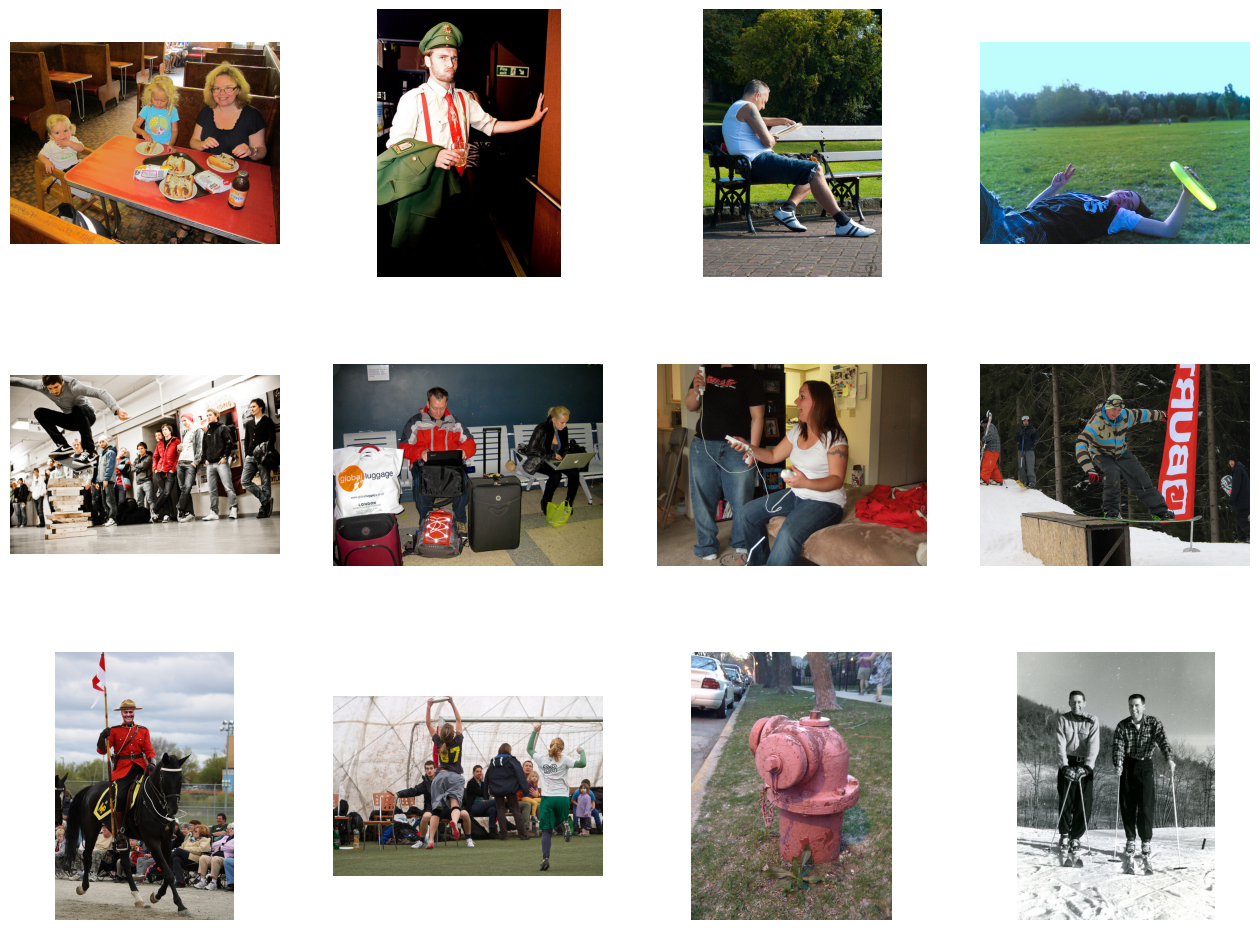

In [22]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix) #shuffle the array with Image ID randomly

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    img = coco.loadImgs(img_path)[0] #load image given ID (dictionary)
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

In [34]:
coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

[445096, 451284, 1449630, 2200365]

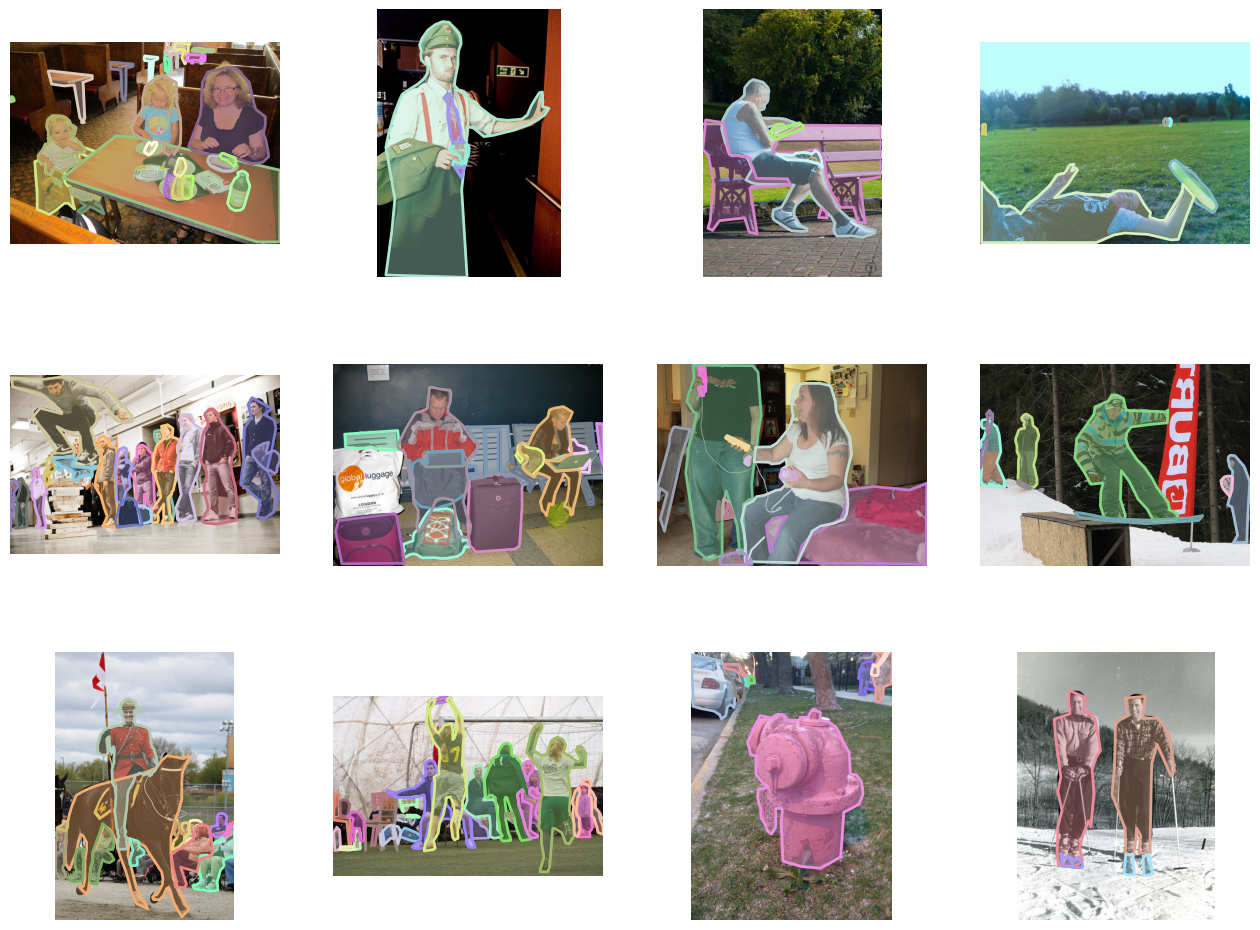

In [35]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None) #coordinates of the segmentation
    anns = coco.loadAnns(annIds) #semantic object
    coco.showAnns(anns) #overlap the segmentation object in the image
    

plt.show()

In [36]:
#@title Images with keypoint objects
annFile = "/content/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=10.05s)
creating index...
index created!


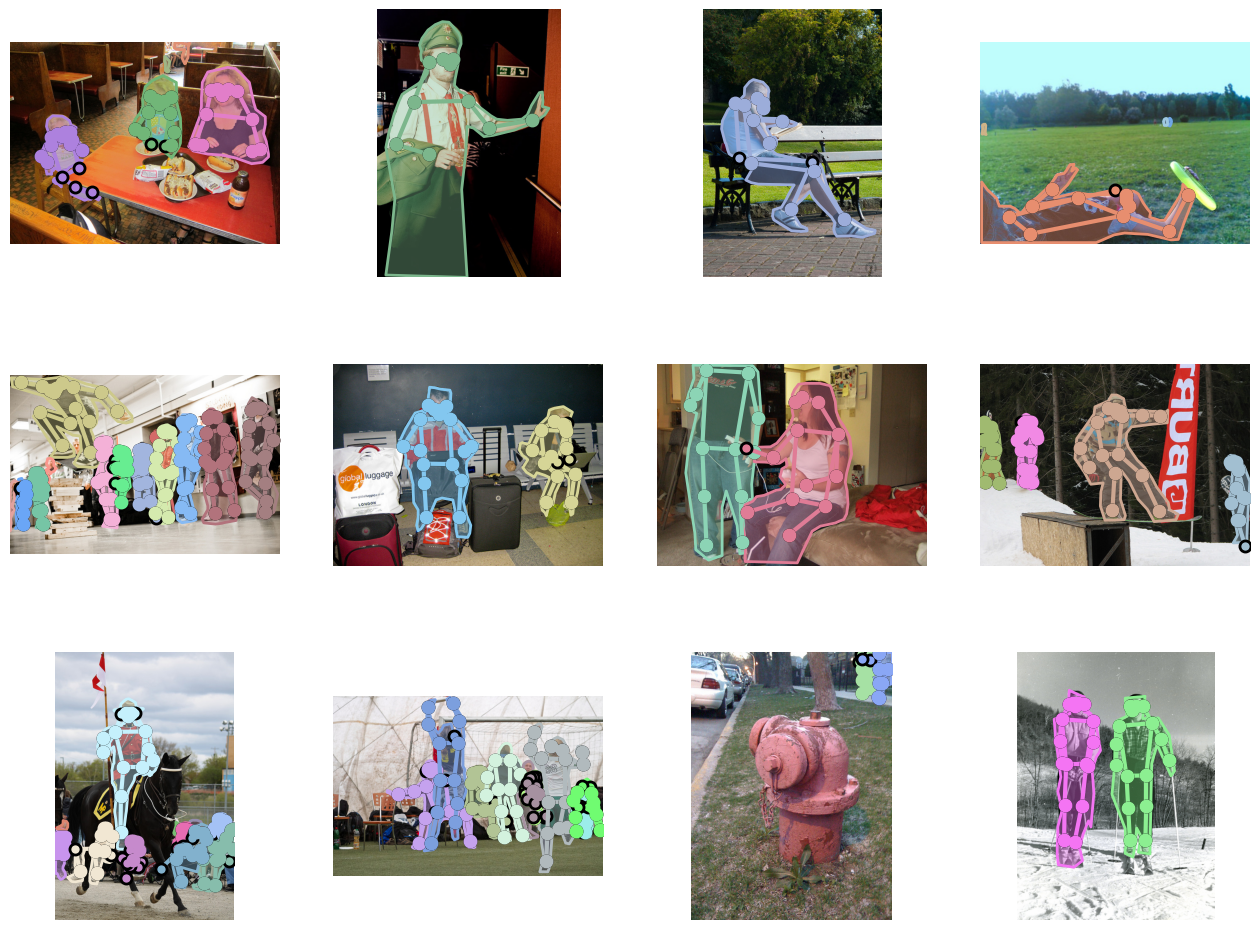

In [37]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

In [38]:
#@title Images with captions
annFile = "/content/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


A group of people sitting at a table in a room.
A woman and her children eating in a restaurant.
A woman sitting at a table with two children.
A family eats chili dogs in a restaurant.
a mom and her two children eating a meal


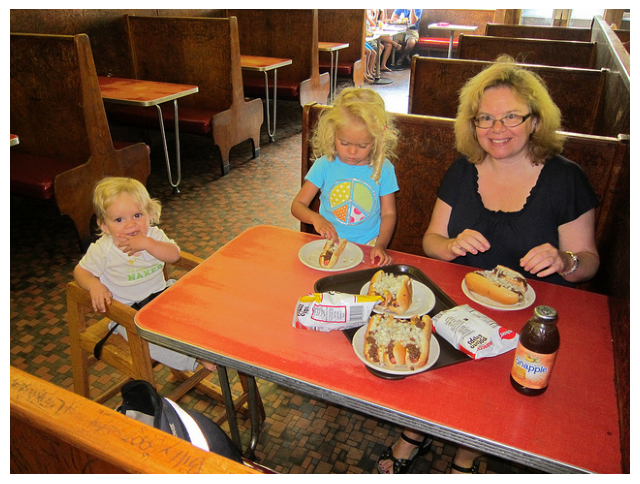

In [40]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.axis('Off')
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

Trainig dataset provides examples of people that do not appear in the main front of the image and it does not describe them

A fat, vintage fire hydrant is painted coral pink.
An old faded red fire hydrant next to the street.
A red fire hydrant on grassy area by a street.
An older fire hydrant sitting next to the road.
This is a pink fire hydrant with chipped paint.


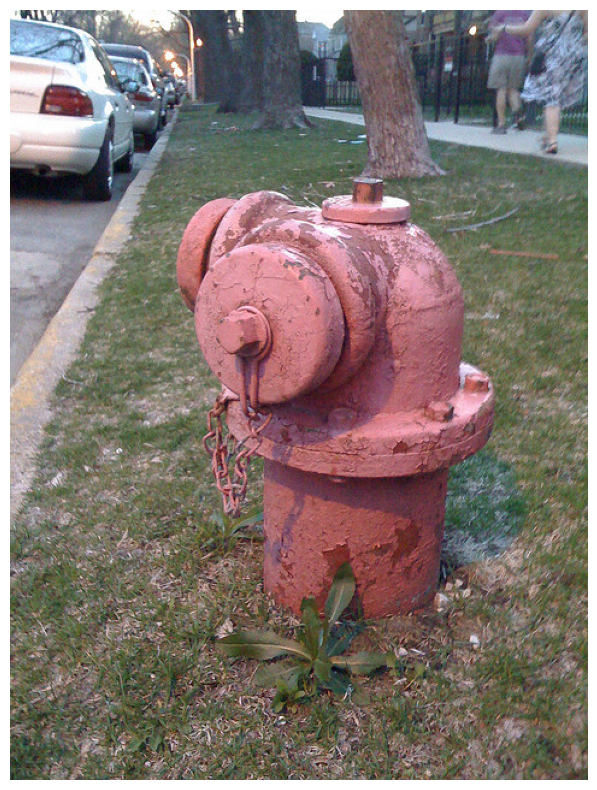

In [41]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.axis('Off')
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

## Image captioning generator